In [1]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geemap as geemap
import geemap.chart as chart
plt.style.use('ggplot')

In [2]:
ee.Authenticate()

Enter verification code:  4/1AVHEtk4Ojmkqvkm5hWCQ7HhleRtRelTYhJ75VYqo3TmuaroyDKrT0jsan2I



Successfully saved authorization token.


In [3]:
geemap.ee_initialize()
ee.Initialize()

# Data collection

In [4]:
aoi = ee.Geometry.Polygon([[[102.4894322423133, 0.8283349585410177],
                            [102.4894322423133, 0.16918388171760845],
                            [103.2639683751258, 0.16918388171760845],
                            [103.2639683751258, 0.8283349585410177]]])
start = '2020-02-01'
end = '2020-03-15'

s1_collection = ee.ImageCollection('COPERNICUS/S1_GRD').filter(ee.Filter.eq('instrumentMode',
                                                                            'IW')).filter(ee.Filter.eq('orbitProperties_pass',
                                                                                                       'DESCENDING')).filterDate(start, end).filterBounds(aoi)
s1_image = s1_collection.first().clip(aoi)

s2_col = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate(start, end).filterBounds(aoi.centroid()).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
s2_image = s2_col.first().clip(aoi)
s2_image

# Data Visualization

In [5]:
visualisation_params = {'min': -25, 'max': 0, 'palette' : ['black', 'white']}

s1VV_image = s1_image.select('VV')
s1VH_image = s1_image.select('VH')

def VV_VH_calc(image):
    VV_VH = image.select('VV').subtract(image.select('VH')).rename('VVVH')
    return image.addBands([VV_VH])

s1_image = VV_VH_calc(s1_image)

Map = geemap.Map()

Map.addLayer(s1_image.select('VH'), vis_params = visualisation_params, name = 'Sentinel 1 - VH')
Map.addLayer(s1_image.select('VV'), vis_params = visualisation_params, name = 'Sentinel 1 - VV')

visualisation_params = {'min': 0, 'max': 10, 'palette' : ['black', 'white']}
Map.addLayer(s1_image.select('VVVH'), vis_params = visualisation_params, name = 'Sentinel 1 - VVVH')

visualisation_params = {"opacity": 1,
                        "bands": ["VV","VH","VVVH"],
                        "min": [-25,-30,0],
                        "max": [-5,-10,10],
                        "gamma": [1,1,1]}

Map.addLayer(s1_image, visualisation_params, name = 'Sentinel 1 - Composite')

visualisation_params = {"opacity": 1,
                        "bands": ["B4","B3","B2"],
                        "min": 0,
                        "max": 3000,
                        "gamma": [1,1,1]}

Map.addLayer(s2_image, visualisation_params, name = 'Sentinel 2 - Composite')

Map.centerObject(aoi, 9)

Map

Map(center=[0.4987653109314045, 102.87670030871976], controls=(WidgetControl(options=['position', 'transparent…

# Distribution

In [6]:
print('min values:\n', s1_image.reduceRegion(ee.Reducer.min(), geometry = aoi, scale = 80).getInfo())
print('max values:\n', s1_image.reduceRegion(ee.Reducer.max(), geometry = aoi, scale = 80).getInfo())

min values:
 {'VH': -49.194778169575095, 'VV': -43.52520110811129, 'VVVH': -6.798410031506556, 'angle': 41.12852478027344}
max values:
 {'VH': 3.663005667109016, 'VV': 14.580778109417086, 'VVVH': 28.331634257584295, 'angle': 46.094459533691406}


In [7]:
def get_Histo(img, band, aoi):
    """
        Function to calculate the distribution of values in one band of an image.
        Inputs:
            - img: ee.Image object
            - band: String with the name of the band
            - aoi: Area Of Interest
    """
    
    sample = img.select(band).sample(aoi, 100)
    histo = chart.feature_histogram(sample, property = band, xlabel = 'Signal [dB]', ylabel = 'Pixel count', title = 'Histogram for ' + band + ' band.',colors = ['#1d6b99'])
    return histo

get_Histo(s1_image, 'VV', aoi)
get_Histo(s1_image, 'VH', aoi)
get_Histo(s1_image, 'VVVH', aoi)

## Transect of signal along river

In [8]:
line = ee.Geometry.LineString(
     [[102.64183, 0.766724],
      [102.696762, 0.772217],
      [102.76474, 0.762605],
      [102.800446, 0.754366],
      [102.829285, 0.7475],
      [102.868423, 0.757112],
      [102.906876, 0.740634],
      [102.950821, 0.712484],
      [102.97554, 0.689826],
      [102.986526, 0.667168],
      [103.007813, 0.629405],
      [103.032532, 0.599195],
      [103.064804, 0.553878],
      [103.089523, 0.544952],
      [103.107376, 0.57173],
      [103.124542, 0.602628],
      [103.132095, 0.644511],
      [103.140335, 0.691199],
      [103.172607, 0.722096],
      [103.218613, 0.76947],
      [103.234406, 0.803113]])
    
Map.addLayer(line, {}, "Transect")
    
transect_VV = geemap.extract_transect(s1_image.select('VV'), line, n_segments=200, reducer='mean', to_pandas=True)
transect_VH = geemap.extract_transect(s1_image.select('VH'), line, n_segments=200, reducer='mean', to_pandas=True)

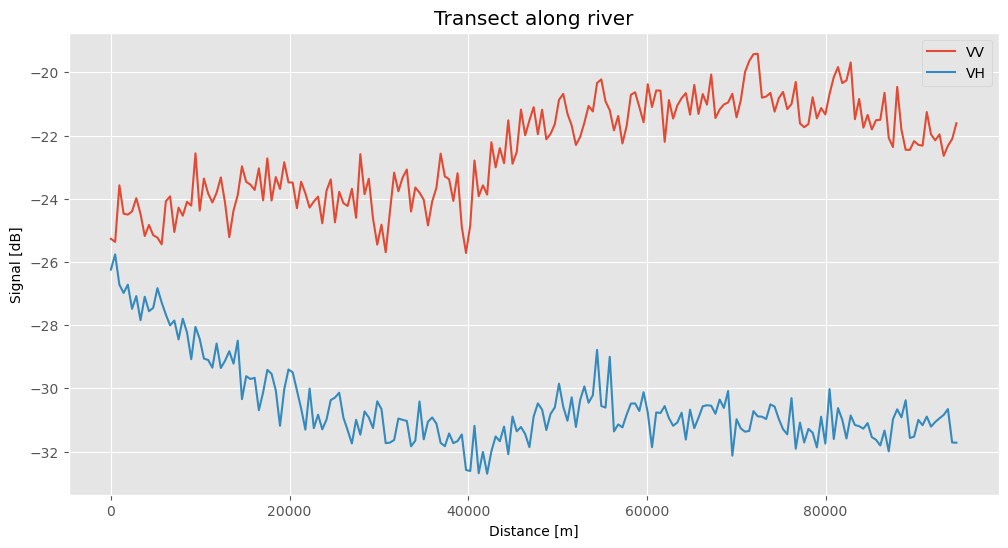

In [9]:
fig = plt.figure(figsize = (12,6))
plt.plot(transect_VV['distance'], transect_VV['mean'],label = 'VV')
plt.plot(transect_VH['distance'], transect_VH['mean'], label = 'VH')
plt.xlabel('Distance [m]')
plt.ylabel('Signal [dB]')
plt.legend()
plt.title('Transect along river')
fig.savefig('Figs/Transect.png')

# Signal response per class

In [10]:
Fo = ee.Geometry.Polygon([[[102.78636900000001, 0.5125462517985078],
                           [102.77953525581266, 0.5115725312497794],
                           [102.7732454833785, 0.5087288786040758],
                           [102.76800035245407, 0.5042416508688976],
                           [102.76421737625903, 0.4984680343044707],
                           [102.7621976772101, 0.4918676114536356],
                           [102.76210201841968, 0.48496577753433134],
                           [102.76393800854353, 0.47831191851490795],
                           [102.76755949793953, 0.47243568002831904],
                           [102.7726782136372, 0.46780480808514724],
                           [102.77888670655263, 0.46478791729119234],
                           [102.78569078418154, 0.4636251499718009],
                           [102.79254884723485, 0.46440906149074107],
                           [102.79891499934999, 0.46707725311236714],
                           [102.80428249880208, 0.4714173387583784],
                           [102.80822409392717, 0.4770838503546624],
                           [102.81042603192084, 0.48362573626394156],
                           [102.81071303406812, 0.4905222641663742],
                           [102.80906224926234, 0.4972244707720315],
                           [102.80560507473483, 0.5031988591620407],
                           [102.80061669851477, 0.5079698655153859],
                           [102.79449419548553, 0.5111577147709337],
                           [102.78772492022561, 0.5125086516699192],
                           [102.78636900000001, 0.5125462517985078]]])

Po = ee.Geometry.Polygon([[[102.90018100000002, 0.6075565324751367],
                           [102.89549734128012, 0.6068891826909317],
                           [102.89118650500302, 0.6049402548521426],
                           [102.88759163592395, 0.6018648848762986],
                           [102.88499888609914, 0.5979078738615405],
                           [102.8836146370444, 0.5933842013956795],
                           [102.88354907221556, 0.5886539527076403],
                           [102.8848074072862, 0.5840936556089992],
                           [102.88728947600671, 0.5800663088860171],
                           [102.890797704289, 0.5768924878729936],
                           [102.89505283752472, 0.5748248271118509],
                           [102.89971616912604, 0.5740279111365169],
                           [102.90441650094493, 0.574565173927461],
                           [102.90877968971373, 0.5763938497273355],
                           [102.91245842788818, 0.579368377086294],
                           [102.91515988862396, 0.5832519852065204],
                           [102.91666903456077, 0.5877355404143579],
                           [102.916865735114, 0.5924621527251358],
                           [102.91573432965278, 0.5970555839647107],
                           [102.91336487510289, 0.6011501962656346],
                           [102.90994597835012, 0.6044200570644531],
                           [102.90574978368326, 0.6066048837782626],
                           [102.90111031008948, 0.6075307628255293],
                           [102.90018100000002, 0.6075565324751367]]])

Pe = ee.Geometry.Polygon([[[102.879752, 0.6869591319860029],
                           [102.8787837934239, 0.6868211798352234],
                           [102.87789265624771, 0.6864183043968776],
                           [102.8771495230981, 0.6857825746170791],
                           [102.87661354739863, 0.684964594666755],
                           [102.87632739274962, 0.6840294758244511],
                           [102.8763138369261, 0.6830516535952951],
                           [102.87657395880923, 0.6821089626307182],
                           [102.87708705255804, 0.6812764410896758],
                           [102.87781227583763, 0.6806203576143126],
                           [102.87869190089145, 0.6801929363686718],
                           [102.8796559096655, 0.6800282000203104],
                           [102.88062756721412, 0.6801392615557152],
                           [102.88152952975418, 0.6805172804949073],
                           [102.88229000118119, 0.6811321665879895],
                           [102.8828484480038, 0.6819349749811321],
                           [102.88316041779892, 0.6828618022023147],
                           [102.88320107764193, 0.6838388728539831],
                           [102.8829671908475, 0.6847884121192694],
                           [102.88247737466027, 0.6856348366351366],
                           [102.8817706183673, 0.6863107709397105],
                           [102.88090317977635, 0.6867624105810197],
                           [102.87994410709251, 0.6869538049768231],
                           [102.879752, 0.6869591319860029]]])

Wa = ee.Geometry.Polygon([[[102.648333, 0.785105],
                           [102.651423, 0.767254],
                           [102.686785, 0.77206],
                           [102.707728, 0.765194],
                           [102.730044, 0.749403],
                           [102.751673, 0.741507],
                           [102.788409, 0.735328],
                           [102.817935, 0.740134],
                           [102.84231, 0.743223],
                           [102.86909, 0.740134],
                           [102.890032, 0.733268],
                           [102.913035, 0.718506],
                           [102.933291, 0.696535],
                           [102.950457, 0.675937],
                           [102.974833, 0.710267],
                           [102.949427, 0.740477],
                           [102.921618, 0.767597],
                           [102.908228, 0.759358],
                           [102.878359, 0.768627],
                           [102.848147, 0.770687],
                           [102.832011, 0.751462],
                           [102.823771, 0.749059],
                           [102.814845, 0.784762],
                           [102.782572, 0.786135],
                           [102.774333, 0.772746],
                           [102.734507, 0.785792],
                           [102.687129, 0.790254],
                           [102.648333, 0.785105]]])

In [11]:
means_Fo = list(s1_image.reduceRegion(ee.Reducer.mean(), Fo).getInfo().values())[:3]
means_Po = list(s1_image.reduceRegion(ee.Reducer.mean(), Po).getInfo().values())[:3]
means_Pe = list(s1_image.reduceRegion(ee.Reducer.mean(), Pe).getInfo().values())[:3]
means_Wa = list(s1_image.reduceRegion(ee.Reducer.mean(), Wa).getInfo().values())[:3]

std_Fo = list(s1_image.reduceRegion(ee.Reducer.stdDev(), Fo).getInfo().values())[:3]
std_Po = list(s1_image.reduceRegion(ee.Reducer.stdDev(), Po).getInfo().values())[:3]
std_Pe = list(s1_image.reduceRegion(ee.Reducer.stdDev(), Pe).getInfo().values())[:3]
std_Wa = list(s1_image.reduceRegion(ee.Reducer.stdDev(), Wa).getInfo().values())[:3]

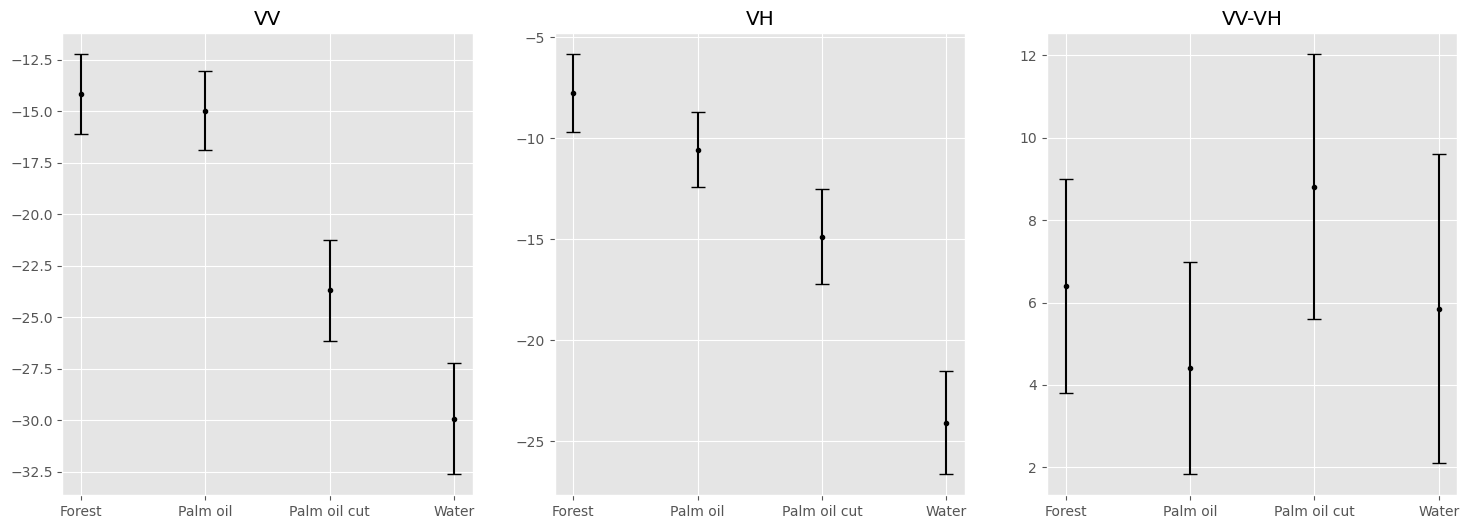

In [12]:
fig, ax = plt.subplots(1,3, figsize = (18,6))

ax[0].errorbar(x = ['Forest','Palm oil', 'Palm oil cut', 'Water'],
             y = np.vstack((means_Fo, means_Po, means_Pe,  means_Wa)).T[0,:],
             yerr=np.vstack((std_Fo, std_Po, std_Pe,  std_Wa)).T[0,:],
             capsize=5, fmt = 'k.')
ax[0].set_title('VV')
ax[1].errorbar(x = ['Forest','Palm oil', 'Palm oil cut', 'Water'],
             y = np.vstack((means_Fo, means_Po, means_Pe,  means_Wa)).T[1,:],
             yerr=np.vstack((std_Fo, std_Po, std_Pe,  std_Wa)).T[1,:],
             capsize=5, fmt = 'k.')
ax[1].set_title('VH')
ax[2].errorbar(x = ['Forest','Palm oil', 'Palm oil cut', 'Water'],
             y = np.vstack((means_Fo, means_Po, means_Pe,  means_Wa)).T[2,:],
             yerr=np.vstack((std_Fo, std_Po, std_Pe,  std_Wa)).T[2,:],
             capsize=5, fmt = 'k.')
ax[2].set_title('VV-VH')

fig.savefig('Figs/Compare_Values_class.png')